# Interaction Module 

In [4]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.ioff()

### ... qualitative module comparison

In [25]:
import itertools
import mantrap
import torch


env = mantrap.environment.Trajectron(ego_position=torch.zeros(2), ego_velocity=torch.zeros(2))
env.add_ado(position=torch.tensor([5, 5]), velocity=torch.tensor([0, -1]))

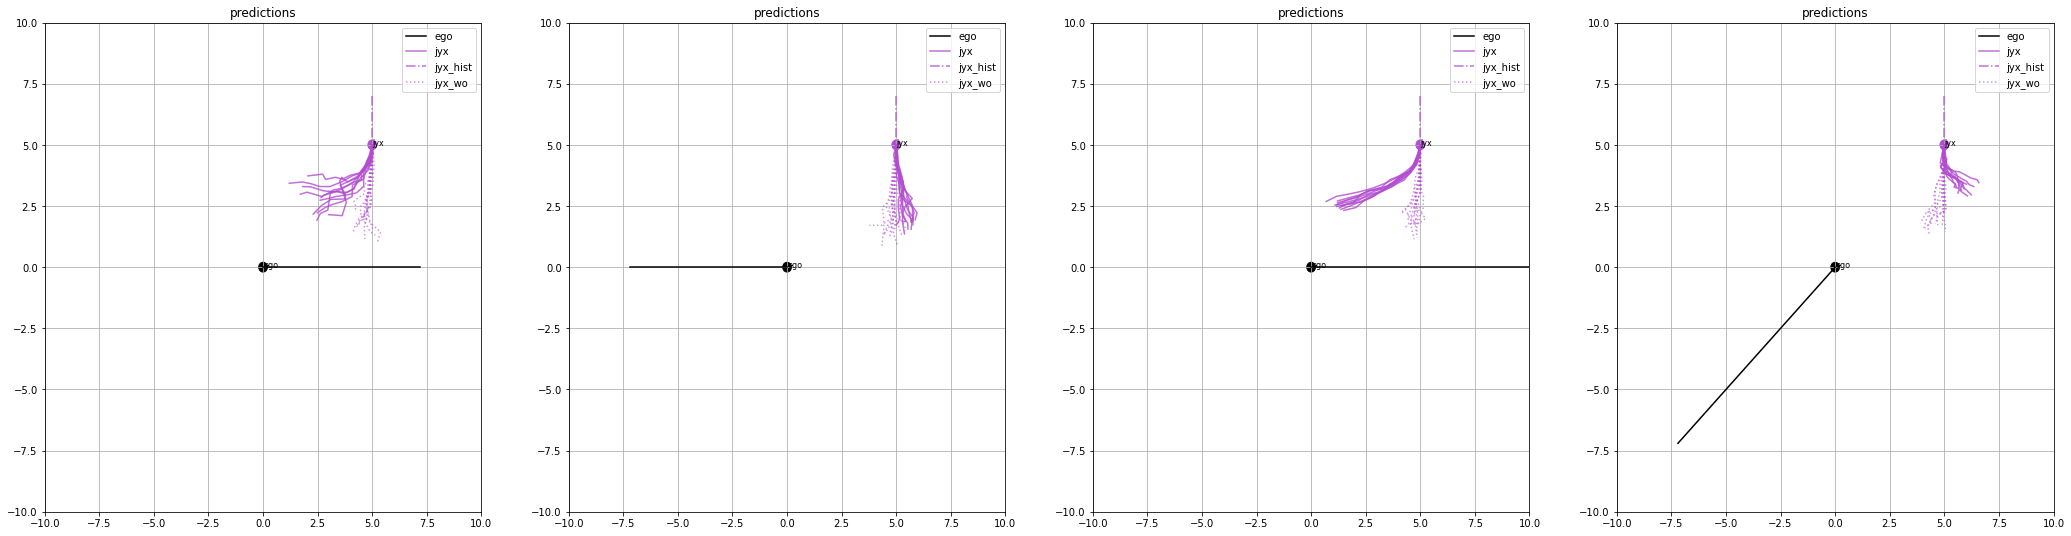

In [26]:
t_horizon = 10
controls_list = [torch.stack([torch.tensor([1, 0])] * t_horizon).float(), 
                 torch.stack([torch.tensor([-1, 0])] * t_horizon).float(), 
                 torch.stack([torch.tensor([2, 0])] * t_horizon).float(), 
                 torch.stack([torch.tensor([-1, -1])] * t_horizon).float()]

fig, ax = plt.subplots(1, len(controls_list), figsize=(len(controls_list) * 9, 9))
for i, ego_controls in enumerate(controls_list):
    env.visualize_prediction_w_controls(ego_controls, ax=ax[i], legend=True)
plt.show()

In [27]:
modules = [mantrap.modules.InteractionProbabilityModule, 
           mantrap.modules.baselines.InteractionPositionModule, 
           mantrap.modules.baselines.InteractionAccelerationModule]

for module_interact, ego_controls in itertools.product(modules, controls_list):
    module = module_interact(env=env, t_horizon=t_horizon)
    ego_trajectory = env.ego.unroll_trajectory(ego_controls, dt=env.dt)
    objective = module.objective(ego_trajectory, ado_ids=env.ado_ids, tag="test")
    
    print(f"{ego_controls[0, :].detach().numpy()}/{module.name} ==> {objective}")

[1. 0.]/interaction_prob ==> 2.8184397220611572
[-1.  0.]/interaction_prob ==> -4.619500160217285
[2. 0.]/interaction_prob ==> 50.0
[-1. -1.]/interaction_prob ==> 21.509368896484375
[1. 0.]/interaction_pos ==> 233.97970581054688
[-1.  0.]/interaction_pos ==> 146.94773864746094
[2. 0.]/interaction_pos ==> 329.5759582519531
[-1. -1.]/interaction_pos ==> 217.95223999023438
[1. 0.]/interact_acc ==> 98.9417495727539
[-1.  0.]/interact_acc ==> 86.2396011352539
[2. 0.]/interact_acc ==> 98.0596923828125
[-1. -1.]/interact_acc ==> 110.7919692993164


### quantitative module comparison

In [2]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.ioff()

import mantrap
import mantrap_evaluation
import pandas as pd
import torch


env = mantrap.environment.Trajectron(ego_position=torch.zeros(2), ego_velocity=torch.zeros(2))
env.add_ado(position=torch.tensor([5, 5]), velocity=torch.tensor([0, -1]))
ego_goal = torch.tensor([0, 8])

modules = {"projection": mantrap.modules.InteractionProbabilityModule, 
           "diff_pos": mantrap.modules.baselines.InteractionPositionModule, 
           "diff_acc": mantrap.modules.baselines.InteractionAccelerationModule}

num_eval = len(modules.keys())
eval_df = pd.DataFrame()
fig, ax = plt.subplots(1, num_eval, figsize=(num_eval * 9, 9))
for i, (label, module) in enumerate(modules.items()):
    print(f"Testing with module {label} ...")
    
    solver_modules = [mantrap.modules.GoalNormModule, mantrap.modules.SpeedLimitModule, module]
    solver = mantrap.solver.IPOPTSolver(env=env, goal=ego_goal, modules=solver_modules)
    
    eval_df_k, ego_trajs, ado_trajs = mantrap_evaluation.evaluate(solver, label=label, time_steps=10)
    eval_df = eval_df.append(eval_df_k)
    mantrap.visualization.visualize_prediction(env=env, 
                                               ego_planned=torch.mean(ego_trajs, dim=0), 
                                               ado_planned=ado_trajs, 
                                               ego_goal=solver.goal, legend=True, ax=ax[i])

Testing with module projection ...
Testing with module diff_pos ...
Testing with module diff_acc ...


In [3]:
eval_df

,ado_effort,directness,ego_effort,final_distance,minimal_distance,runtime[s]
projection,8.666515,0.907958,0.854784,0.335333,4.894305,3.259840
diff_pos,10.016588,0.505228,0.967850,0.619065,3.928768,3.338371
diff_acc,7.634391,0.891144,0.534357,0.440440,3.585183,3.423933


In [4]:
plt.savefig("/Users/sele/Desktop/inter_comp.png")

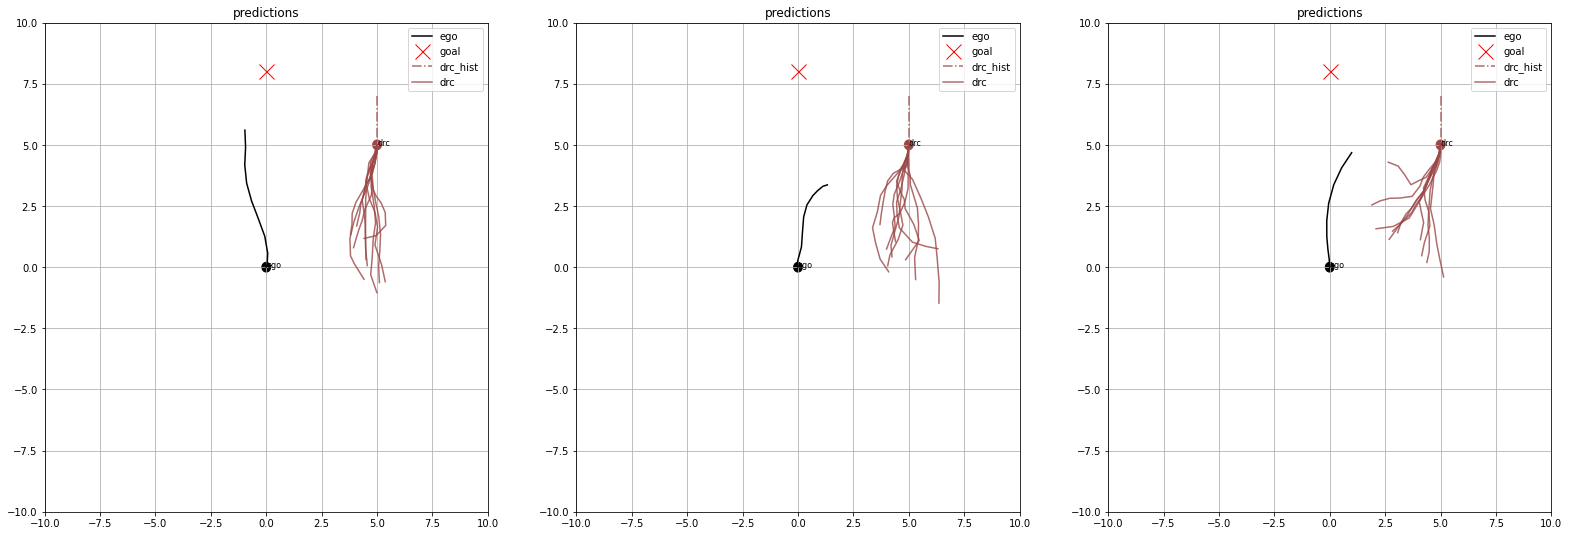

In [5]:
plt.show()